In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import multiprocessing
from multiprocessing import Pool
from bb_binary import FrameContainer, Repository, load_frame_container
import pandas as pd
import numpy as np
from collections import namedtuple 
import networkx as nx

from pandas import DataFrame, Series
from collections import Counter
import matplotlib.pyplot as plt
import bib.preprocessing as prep
import seaborn as sns
%matplotlib inline 

# How often and how long do bees interact (are bees close to each other)?

Looking at all bees for a complete day (24 hours), I want to find out how often a bee pair is detected, also looking at the distribution.

In [3]:
# packt immer die 4 Kameradateien zusammen
def get_files(path):
    repo = Repository(path)
    file = list(repo.iter_fnames())
    a = [f.split('/')[-1].split("_")[1] for f in file]
    l = len(a)/4
    npa = np.array(file).reshape(int(l),4)
    return npa

In [ ]:
#path = "/storage/mi/aschle/1day/20150822/"

In [4]:
path = "../data/1h/2015082215/"

In [5]:
files = get_files(path)

In [6]:
len(files)

10

In [13]:
def generate_timeseries_pairs(files):
    
    xmax = 3000
    distance = 160
    confidence = 0.95
    
    # one df per cam
    dataframes = [DataFrame(),DataFrame(),DataFrame(),DataFrame()]

    for e, file_list in enumerate(files):
        for i in list(range(4)):
            fc = load_frame_container(file_list[i])
            df = prep.get_dataframe2(fc)
            df = prep.calcIds(df,confidence)
            df['frame_idx'] = df['frame_idx'] + e*1024

            camIdx = int(file_list[i].split("/")[-1].split("_")[1])
            dataframes[camIdx] = pd.concat([dataframes[camIdx], df])

    # cam 0 und cam1 nach rechts verschieben
    dataframes[0].xpos = dataframes[0].xpos + xmax
    dataframes[1].xpos = dataframes[1].xpos + xmax

    # Seiten zusammenfugen
    side0 = pd.concat([dataframes[3], dataframes[0]])
    side1 = pd.concat([dataframes[2], dataframes[1]])

    close1 = prep.get_close_bees_ckd(side0, distance)
    close2 = prep.get_close_bees_ckd(side1, distance)

    close = pd.concat([close1,close2])

    return bee_pairs_to_timeseries(close)

In [14]:
def bee_pairs_to_timeseries(df):
    close = df[['frame_idx', 'id_x', 'id_y']]
    close['pair'] = list(zip(close.id_x, close.id_y))
    u_pairs = close.pair.unique()
    col = close.frame_idx.unique()
    dft = DataFrame(0, index=u_pairs, columns=col)
    gr = close.groupby('frame_idx')

    for i, group in gr:
        l = group['pair']
        dft.loc[l,i] = 1

    return dft

In [20]:
%time dft = generate_timeseries_pairs(files)

CPU times: user 20min 57s, sys: 5.82 s, total: 21min 3s
Wall time: 21min


In [21]:
dft.shape

(147430, 10240)

In [42]:
dft.to_pickle("/storage/mi/aschle/dft-1h-2015082215.pickle")

## Number of 1 per pair and number of 0 per pair

In [22]:
dft_summen = DataFrame()
dft_summen["sum1"] = dft.sum(axis=1)

In [23]:
dft_summen["sum0"] = (dft.shape[1]) - dft_summen['sum1']

In [24]:
# Numer of unique Bee Pairs
len(dft_summen.index)

147430

### Number of 1 = Pair detected

In [25]:
len(files)*1024

10240

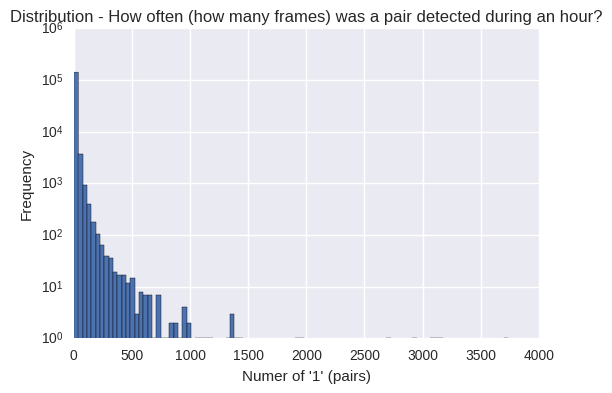

In [26]:
ax = dft_summen.sum1.hist(bins=100, log=True)
ax.set_xlabel("Numer of '1' (pairs)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution - How often (how many frames) was a pair detected during an hour?")

In [27]:
freq = Counter(dft_summen.sum1)

In [28]:
dft_summen.sum1.describe()

count    147430.000000
mean          9.140324
std          33.546379
min           1.000000
25%           1.000000
50%           3.000000
75%           8.000000
max        3735.000000
Name: sum1, dtype: float64

### Number of 0 = Pair not detected

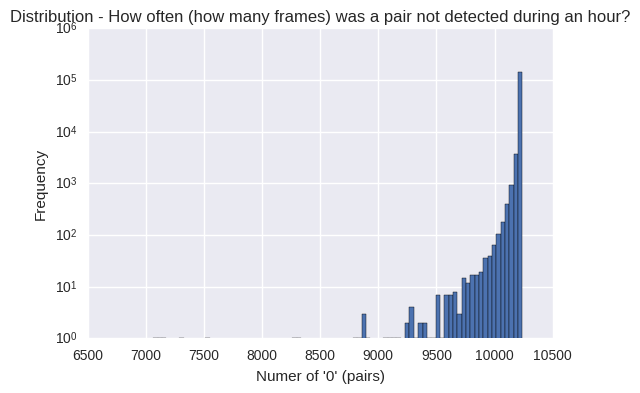

In [29]:
ax = dft_summen.sum0.hist(bins=100, log=True)
ax.set_xlabel("Numer of '0' (pairs)")
ax.set_ylabel("Frequency")
ax.set_title("Distribution - How often (how many frames) was a pair not detected during an hour?")

In [30]:
dft_summen.sum0.describe()

count    147430.000000
mean      10230.859676
std          33.546379
min        6505.000000
25%       10232.000000
50%       10237.000000
75%       10239.000000
max       10239.000000
Name: sum0, dtype: float64

## Length of 1

In [31]:
def get_ketten_len(kette, val):
    kette = kette.apply(str)
    s = kette.str.cat(sep='')
    ss = s.split(val)
    return [len(x) for x in ss if len(x) > 0]

In [32]:
%time chains1 = dft.apply(get_ketten_len, axis=1, args=["0"])

CPU times: user 14min 51s, sys: 944 ms, total: 14min 52s
Wall time: 14min 44s


In [33]:
%time list_1 = [j for i in chains1 for j in i]

CPU times: user 48 ms, sys: 4 ms, total: 52 ms
Wall time: 51 ms


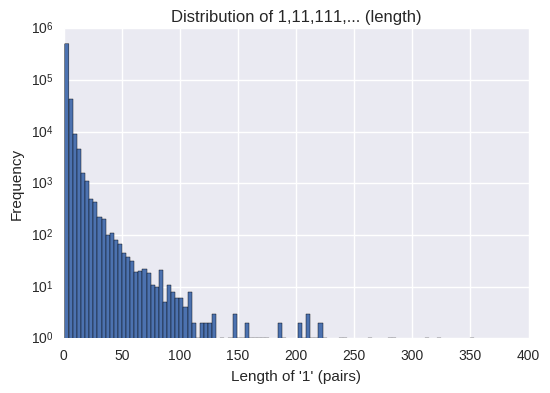

In [34]:
plt.hist(list_1, bins=100, log=True, )
plt.xlabel("Length of '1' (pairs)")
plt.ylabel("Frequency")
plt.title("Distribution of 1,11,111,... (length)")

In [35]:
DataFrame(list_1).describe()

,0
count,563063.000000
mean,2.393263
std,3.685632
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,353.000000


### Length of 0

In [36]:
%time chains0 = dft.apply(get_ketten_len, axis=1, args=["1"])

CPU times: user 11min 39s, sys: 1.05 s, total: 11min 40s
Wall time: 11min 32s


In [37]:
list_0 = [j for i in chains0 for j in i]

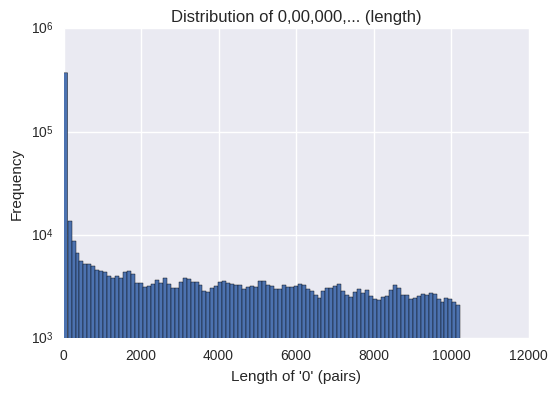

In [38]:
(n, bins, patches) = plt.hist(list_0, bins=100, log=True)
plt.xlabel("Length of '0' (pairs)")
plt.ylabel("Frequency")
plt.title("Distribution of 0,00,000,... (length)")

In [39]:
DataFrame(list_0).describe()

,0
count,710240.000000
mean,2123.698527
std,3037.781182
min,1.000000
25%,2.000000
50%,55.000000
75%,3974.000000
max,10239.000000
